# PP5 - Mildew Detection in Cherry Leaves

## Notebook 3 - Modelling and Evaluation

### Objectives

* Fetch data from kaggle and prepare data for further processes.


### Inputs

* Dataset: [Kaggle](https://www.kaggle.com/datasets/codeinstitute/cherry-leaves/data)

| **input**       |          |        |
|-----------------|----------|--------|
| **train/**      | healthy  | mildew |
| **test/**       | healthy  | mildew |
| **validation/** | healthy  | mildew |


### Outputs


---

## Preparation

### Manage Directories

**Change working directory**

In [12]:
import os

In [13]:
current_dir = os.getcwd()
current_dir

'/workspace/ml-mildew-detection-in-cherry-leaves'

In [14]:
working_dir = os.getcwd()
working_dir

'/workspace/ml-mildew-detection-in-cherry-leaves'

In [15]:
os.chdir('/workspace/ml-mildew-detection-in-cherry-leaves')
print("You set a new current directory")

You set a new current directory


**Set Input Directory**

In [16]:
dataset_dir= 'input/cherry-leaves'
train_path = dataset_dir + '/train'
val_path = dataset_dir + '/validation'
test_path = dataset_dir + '/test'
print(f"Train Set Path: {train_path}")
print(f"Validation Set Path: {val_path}")
print(f"Test Set Path: {test_path}")

Train Set Path: input/cherry-leaves/train
Validation Set Path: input/cherry-leaves/validation
Test Set Path: input/cherry-leaves/test


**Set Output Directory**

In [17]:
version = 'v1'

In [18]:
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(working_dir) and version in os.listdir(working_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

print(file_path)

Old version is already available create a new version.
outputs/v1


**Set Label Names**

In [19]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'mildew']


**Load Image shape**

In [20]:
import joblib

In [21]:
image_shape = joblib.load(filename=f'outputs/{version}/avg_image_shape_train.pkl')
image_shape

(256, 256, 3)

---

## Analysis of Data Distribution across Sets and Labels

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")


In [58]:
def display_data_distribution(dataset_dir, file_path):
    '''
    Display the distribution of data across different sets and labels

    Parameters:
        dataset_dir (str): The directory containing the datasets
        file_path (str): The directory where the output images will be saved

    Returns:
        None
    '''
    data = []
    for folder in ['test', 'train', 'validation']:
        folder_path = os.path.join(dataset_dir, folder)
        for label in os.listdir(folder_path):
            label_path = os.path.join(folder_path, label)
            frequency = len(os.listdir(label_path))
            data.append({'Set': folder, 'Label': label, 'Frequency': frequency})

    df_freq = pd.DataFrame(data)

    custom_palette = sns.color_palette("viridis", len(df_freq['Label'].unique()))

    # Display numerical data
    plt.figure(figsize=(8, 4))
    plt.axis('off')
    table = plt.table(cellText=df_freq.values,
                      colLabels=df_freq.columns,
                      cellLoc='left',
                      loc='left')
    table.set_fontsize(10)
    for key, cell in table.get_celld().items():
        cell.set_linestyle('-')
        cell.set_edgecolor('lightgray')
    plt.savefig(os.path.join(file_path, 'labels_distribution_table.png'), bbox_inches='tight', dpi=150)
    plt.show()

    # Plotting the bar plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette=custom_palette)
    plt.title('Distribution of Labels in Different Sets', fontsize=16, fontweight='bold')
    plt.xlabel('Set', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.savefig(os.path.join(file_path, 'labels_distribution_bar.png'), bbox_inches='tight', dpi=150)
    plt.show()

    # Plotting the pie chart
    plt.figure(figsize=(4, 4))
    plt.pie(df_freq.groupby('Label')['Frequency'].sum(), labels=None,
            autopct='%1.1f%%', startangle=140, colors=custom_palette)
    plt.title('Total Data in Each Label', fontsize=16, fontweight='bold')
    plt.axis('equal')
    plt.legend(df_freq['Label'].unique(), fontsize=12, loc='lower right')
    plt.savefig(os.path.join(file_path, 'labels_pie_chart.png'), bbox_inches='tight', dpi=150)
    plt.show()

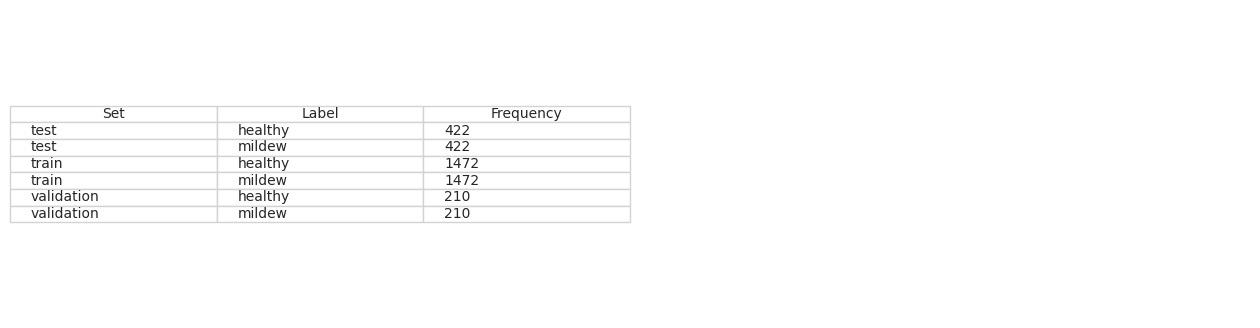

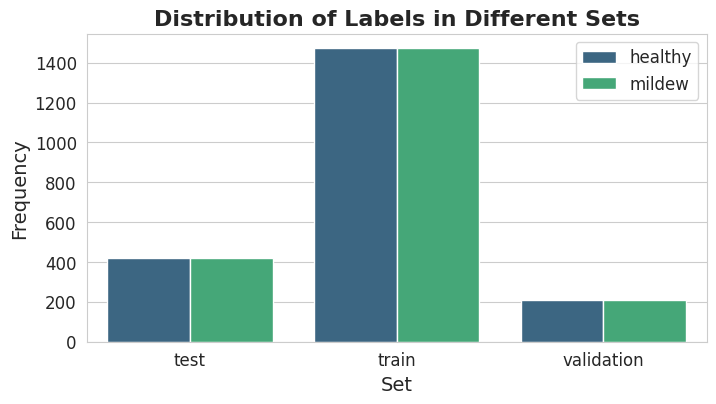

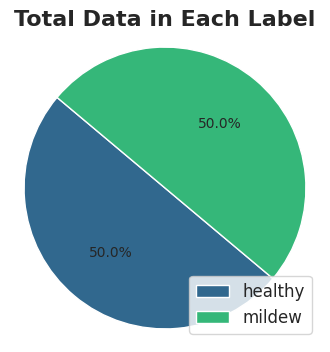

In [59]:
display_data_distribution(dataset_dir, file_path)


---

## Image Augmentation

### Setup Augmentation

**Import Libraries**

In [60]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-04-21 12:57:28.119961: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


**Augmentation Pipeline**

In [80]:
augmentation_data = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    rotation_range=10,
    shear_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    rescale=1.0/255.0,
)

**Batch Size**

In [81]:
batch_size = 20

**Augmentation Train image Set**

In [82]:
train_set = augmentation_data.flow_from_directory(
    train_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

**Augmentation Validation image Set**

In [83]:
validation_set = augmentation_data.flow_from_directory(
    val_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

**Augmentation Test image Set**

In [84]:
test_set = augmentation_data.flow_from_directory(
    test_path,
    target_size=image_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'mildew': 1}

### Plot Augmented Images

In [85]:
label_names = {i: label for i, label in enumerate(labels)}
print('Label names:', label_names)


Label names: {0: 'healthy', 1: 'mildew'}


**Augmented Train Image Set**

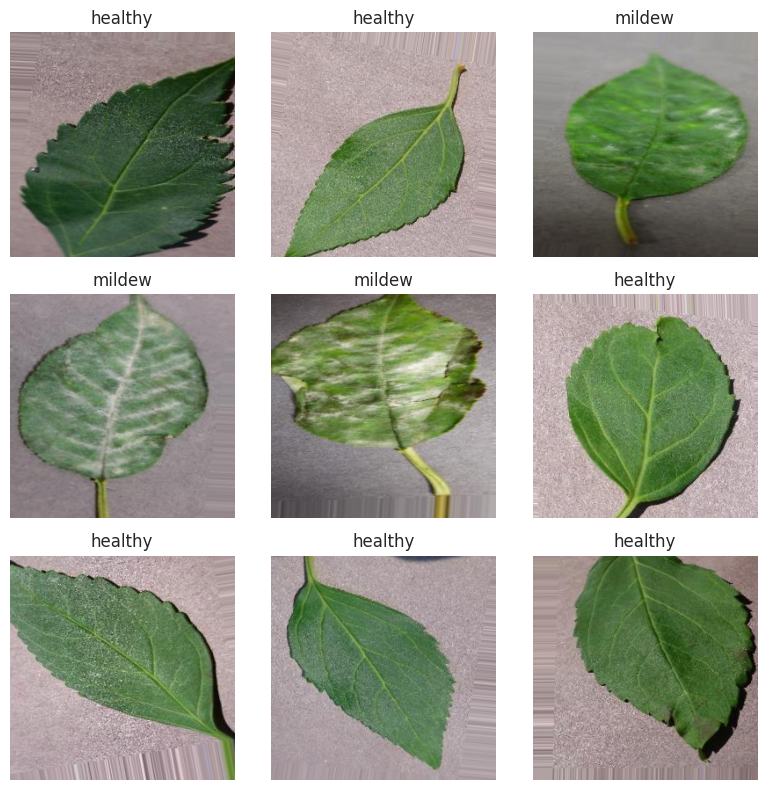

In [86]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(train_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Augmented Validation Image Set**

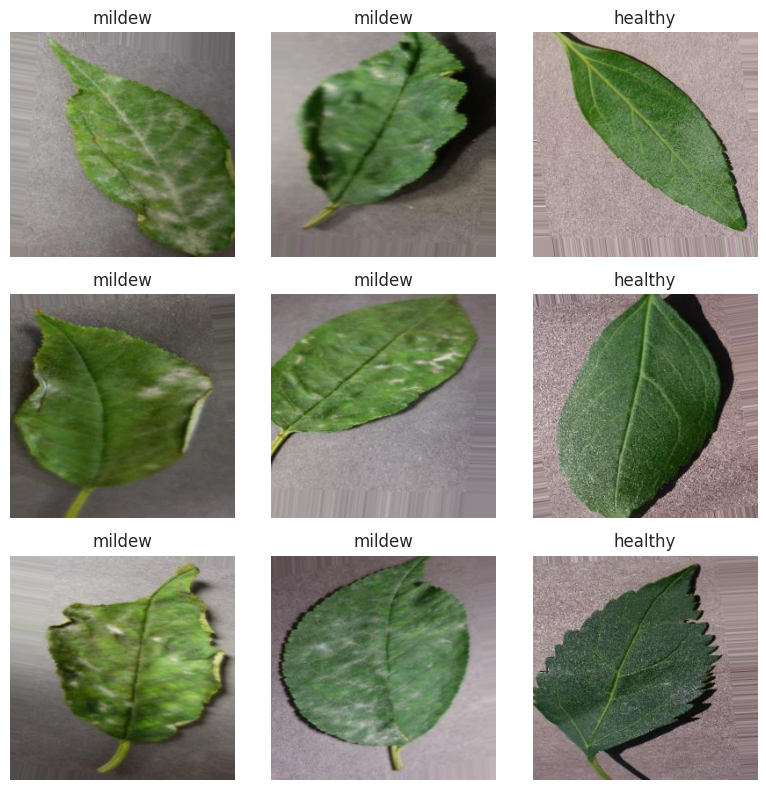

In [87]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(validation_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Augmented Test Image Set**

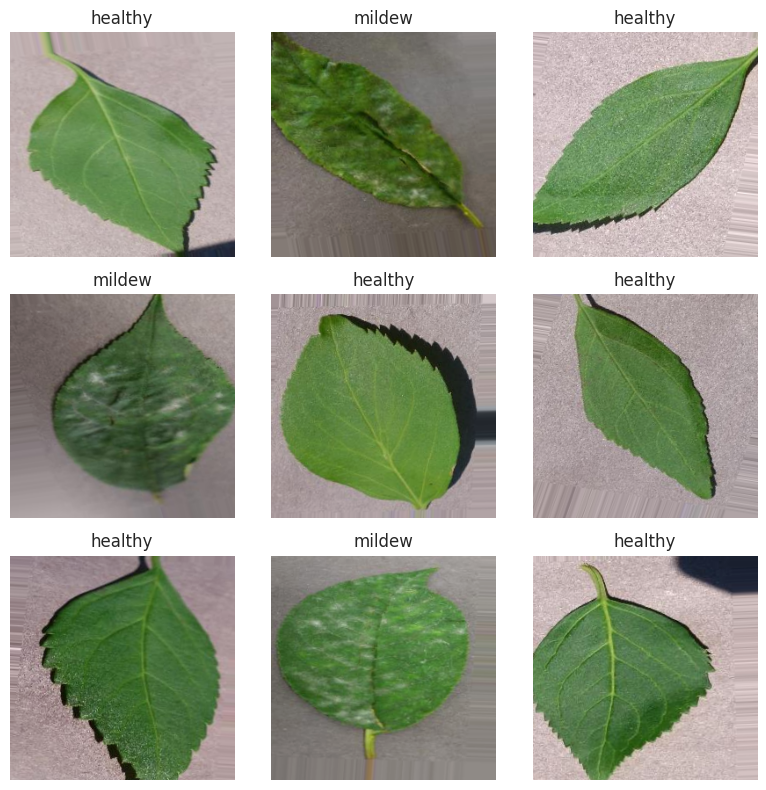

In [88]:
fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i in range(9):
    img, label = next(test_set)
    label_name = label_names[label[0]]
    
    axes[i // 3, i % 3].imshow(img[0])
    axes[i // 3, i % 3].set_title(label_name)
    
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

**Save class_indicies**

In [89]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---